In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split


def load_yolo_model(eval = True):
    """
    Loads the YOLO model for object detection.

    Parameters:
    eval (bool): If True, sets the model to evaluation mode. Default is True.

    Returns:
    yolo (YOLO): The loaded YOLO model.
    """
    yolo = YOLO("yolov8n-pose.pt")
    
    return yolo

def load_images(image_path):
    """
    Load images from the specified image path and assign labels based on folder names.
    
    Parameters:
    image_path (str): The path to the folder containing the images.
    
    Returns:
    list: A list of tuples, where each tuple contains an image and its corresponding label.
    """
    folders = ['green', 'yellow', 'red']
    labels = [2, 1, 0]
    
    images = [(image, label) 
              for folder, label in zip(folders, labels) 
              for image in load_images_in_folder(image_path + folder + "/")]
    
    return images
    
def load_images_in_folder(path: str, file_ending: str = ".jpg") -> np.ndarray:

    images = []

    files = os.listdir(path)
    files.sort()
    for cur in files:
        if not cur.endswith(file_ending):
            continue

        try:
            img = cv2.imread(path + cur)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        except:
            continue

    return np.array(images)

In [2]:
def visualize_output(image, keypoints):
    """
    Visualize the output model on the input image.

    Parameters:
    image (numpy.ndarray): The original image.
    keypoints (numpy.ndarray): Array of keypoints for pose estimation.
    """

    result_image = image.copy()

    # Draw keypoints
    for keypoint in keypoints:
        for x, y in keypoint:
            cv2.circle(result_image, (int(x), int(y)), 20, (255, 0, 0), -1)
    
    return result_image

def plot_results(image, mode="inline", scale=1):
    """
    Displays an image using either a popup window or inline display.

    Parameters
    ----------
    image : numpy.ndarray or CV2 image
        The image to display.
    mode : str, optional
        The display mode. Must be either "popup" or "inline". If "popup", the image is displayed in a popup window. If "inline", the image is displayed inline in the notebook. Default is "inline".
    scale : float, optional
        The scaling factor for the image. Default is 1.

    Raises
    ------
    ValueError
        If the mode is not "popup" or "inline".
    """
    
    if type(image) is np.ndarray:
        image = Image.fromarray(image)
    
    if mode == "popup":
        pass
    elif mode == "inline":
        if type(image) == np.ndarray:
            # Convert from BGR to RGB (because OpenCV uses BGR order for color channels, whereas PIL uses RGB.)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image_rgb)
    else:
        raise ValueError("Mode must be either 'popup' or 'inline'")

    if type(image) is np.ndarray:
        cv2.imshow('Image', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        width, height = image.size
        display(image.resize((int(width*scale), int(height*scale))))

In [3]:
images = load_images("example_images/")


0: 640x480 1 person, 74.8ms
Speed: 2.4ms preprocess, 74.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


tensor([[[1511.1055, 1522.6907],
         [1602.8777, 1406.0059],
         [1494.5975, 1423.6484],
         [1929.7957, 1397.2090],
         [   0.0000,    0.0000],
         [2211.6421, 2097.9741],
         [1764.4586, 1859.8331],
         [1924.2646, 3073.0376],
         [1560.7609, 2410.8960],
         [1083.2833, 2959.3511],
         [1183.7020, 2611.0095],
         [1846.7168, 3251.7131],
         [1581.3855, 3036.5781],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000],
         [   0.0000,    0.0000]]])

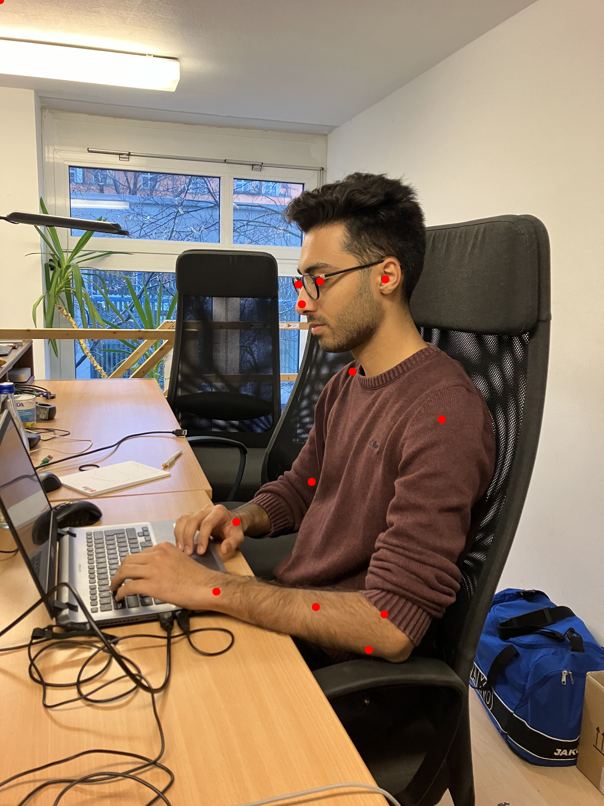

In [4]:
# Example evaluation on image with keypoint detection
image = images[0][0]

yolo = load_yolo_model()
result = yolo(image)

keypoints = result[0].keypoints.xy
display(keypoints)
plot_results(visualize_output(image, keypoints), scale = 0.2)

In [5]:
class KeypointClassifier(nn.Module):
    def __init__(self, num_keypoints, num_classes):
        """
        Initializes a KeypointClassifier object.

        Args:
            num_keypoints (int): The number of keypoints.
            num_classes (int, optional): The number of classes. Defaults to 3.
        """
        super(KeypointClassifier, self).__init__()
        
        # Keypoints times 2 because each keypoint has an x and y coordinate
        self.classifier = nn.Sequential(
            nn.Linear(num_keypoints * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        """
        Performs forward pass through the classifier.

        Args:
            keypoints_3d (torch.Tensor): The 3D keypoints tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        
        x = x.flatten()
        x = self.classifier(x)
        return x

In [6]:
def train_classifier_on_keypoints(classifier, device, train_data, criterion, optimizer, num_epochs=10):
    """
    Trains a classifier on the given keypoints and labels.

    Args:
        classifier (nn.Module): The classifier model.
        keypoints (list): List of keypoints.
        labels (list): List of labels.
        criterion (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        num_epochs (int, optional): The number of epochs. Defaults to 10.

    Returns:
        nn.Module: The trained classifier.
    """
    
    classifier.to(device)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for keypoints, label in train_data:
            keypoints = keypoints.to(device)
            label = label.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = classifier(keypoints)

            # Compute loss
            loss = criterion(outputs, label)

            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")
        
    return classifier

def get_keypoints(yolo_model, images):
    keypoints = [result.keypoints.xy for result in yolo_model([image[0] for image in images])]
    
    return torch.stack(keypoints)

def encode_label(label, num_classes = 3):
    one_hot_label = torch.zeros(num_classes)
    one_hot_label[label] = 1
    
    return one_hot_label

In [7]:
yolo = load_yolo_model()
classifier = KeypointClassifier(17, 3)

keypoints = get_keypoints(yolo, images)
labels = np.array([encode_label(image[1]) for image in images])
labels = torch.tensor(labels)

data = list(zip(keypoints, labels))

indices = list(range(len(data)))

train_indices, test_indices, _, _ = train_test_split(indices, indices, test_size=0.2, random_state=0)
train_data = [data[i] for i in train_indices]
test_data = [data[i] for i in test_indices]

print("Number of training samples:", len(train_data))
print("Number of test samples:", len(test_data))


0: 640x480 1 person, 1: 640x480 1 person, 2: 640x480 1 person, 3: 640x480 1 person, 4: 640x480 1 person, 5: 640x480 1 person, 6: 640x480 1 person, 7: 640x480 1 person, 520.8ms
Speed: 5.9ms preprocess, 65.1ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 480)
Number of training samples: 6
Number of test samples: 2


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_classifier = train_classifier_on_keypoints(classifier, device, train_data, criterion, optimizer)

Epoch 1/10, Loss: 3287.9091
Epoch 2/10, Loss: 1975.4697
Epoch 3/10, Loss: 1181.4502
Epoch 4/10, Loss: 1888.0767
Epoch 5/10, Loss: 1356.0686
Epoch 6/10, Loss: 1298.7340
Epoch 7/10, Loss: 340.7148
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 1688.3948
Epoch 10/10, Loss: 450.9537


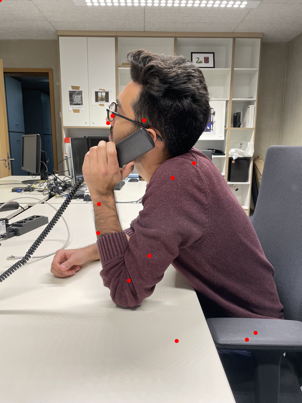

True label: 0, Predicted label: 1


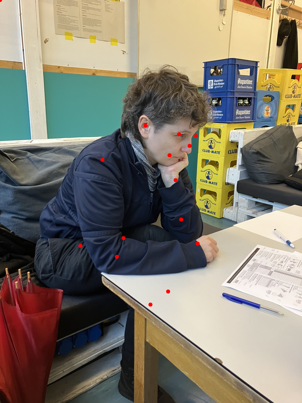

True label: 1, Predicted label: 1


In [9]:
trained_classifier.eval()

for idx, (keypoints, label) in zip(test_indices, test_data):
    image = images[idx][0]
    
    output = trained_classifier(keypoints)
    prediction = torch.argmax(output)
    true_label = torch.argmax(label)
    
    visualizted_image = visualize_output(image, keypoints)
    plot_results(visualizted_image, scale = 0.1)
    print(f"True label: {true_label}, Predicted label: {prediction.item()}")